In [1]:
from lib.NeuralNet import *
from lib.Optimizer import Adam,SGD,AdaGrad

| TIME:     0.19s | EPOCH:     1 | LOSS: 0.10482344 |
| TIME:    11.07s | EPOCH:   100 | LOSS: 0.02351040 |
| TIME:    21.70s | EPOCH:   200 | LOSS: 0.01041306 |
| TIME:    32.21s | EPOCH:   300 | LOSS: 0.00778596 |
| TIME:    42.56s | EPOCH:   400 | LOSS: 0.00662164 |
| TIME:    52.65s | EPOCH:   500 | LOSS: 0.00506212 |
| TIME:    62.91s | EPOCH:   600 | LOSS: 0.00348298 |
| TIME:    73.00s | EPOCH:   700 | LOSS: 0.00280794 |
| TIME:    83.20s | EPOCH:   800 | LOSS: 0.00244570 |
| TIME:    93.23s | EPOCH:   900 | LOSS: 0.00211576 |
| TIME:   103.52s | EPOCH:  1000 | LOSS: 0.00196321 |


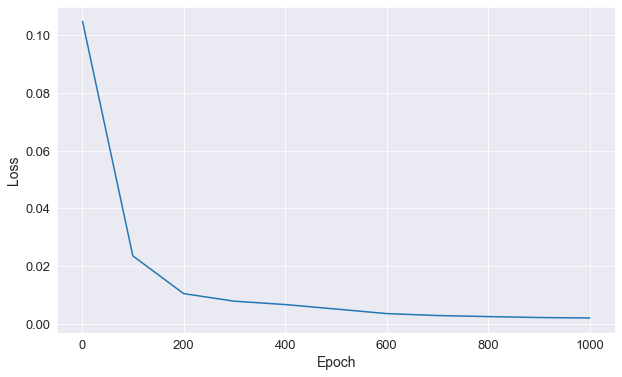

In [2]:
X = np.random.rand(5000,100)
y = np.random.rand(5000,1)
W1,b1,W2,b2,W3,b3 = FitModel(X,y,n_iter=1000,batch_size=500,lr=1e-3,update=Adam,print_every_epochs=100,print_graph=True)